In [6]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from time import time
import matplotlib.pyplot as plt

from numba import njit
import tensorflow as tf

import sys
sys.path.append('../../../')
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [133]:
# read data
data = pd.read_csv('sub-003_task-pdm_acq-outsideMRT_runs_beh_n200lat.csv')
# combine rt and accuaracy
data['response_corr'] = data['response_corr'].replace(0,-1)
# two different responses, [rt*acc, N200 latency]
data_rt_z = np.array([data['response_time']*data['response_corr'], data['n200lat']]).T
data_rt_z = data_rt_z[data_rt_z[:,1]>-10]

### Model 1a

In [102]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)
    
    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data



# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial"
)

Networks loaded from ../../checkpoint/N200_single_trial/ckpt-1000


In [103]:
#data_rt_z[data_rt_z[:,1]>-10].shape

In [104]:
# Validate (quick and dirty) by a specific real data
data_rt_z = data_rt_z[data_rt_z[:,1]>-10]
n_samples = 5000
n_trials = 5000

param_samples_model1a = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model1a = batch_simulator(param_samples_model1a, n_trials).astype(np.float32)

In [105]:
# paramter estimation

In [106]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
print(param_samples_model1a.mean(axis=0))
print(param_samples_model1a.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']
[1.4845763  1.4062002  0.65282893 0.1581522  0.09772325 0.01798696
 0.02032629]
[0.19503058 0.08954567 0.03710019 0.00560025 0.01363776 0.00586343
 0.00728758]


### Model 1b

In [107]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # mu_tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, mu_tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    ndt_trial = np.random.normal(mu_tau_e + mu_tau_m, varsigma)

    # N200 latency
    z = np.random.normal(ndt_trial - mu_tau_m, sigma)
    
    if evidence >= boundary:
        choicert =  ndt_trial + rt
        
    else:
        choicert = -ndt_trial - rt
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, mu_tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, mu_tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_ndt"
)

# Variable n_trials
def prior_N(n_min=60, n_max=300):
    """
    A prior or the number of observation (will be called internally at each backprop step).
    """

    return np.random.randint(n_min, n_max + 1)

Networks loaded from ../../checkpoint/N200_single_trial_ndt/ckpt-500


In [108]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model1b = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model1b = batch_simulator(param_samples_model1b, n_trials).astype(np.float32)

In [109]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
print(param_samples_model1b.mean(axis=0))
print(param_samples_model1b.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']
[1.5504997  1.3707421  0.65953946 0.14037403 0.10418948 0.02211596
 0.00984168]
[0.19941488 0.07359114 0.04038087 0.00486036 0.01281771 0.00599424
 0.00656257]


### Model 1c

In [110]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.4,  0.6,  0.1, 0.1), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    

    # N200 latency
    z = 0
    while True:
        # visual encoding time for each trial
        tau_e_trial = mu_tau_e + np.random.uniform(-.5*np.sqrt(12)*varsigma,.5*np.sqrt(12)*varsigma)
        z = np.random.normal(tau_e_trial, sigma)
        if z > 0 and z < .5:
            break

    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_trunc"
)

Networks loaded from ../../checkpoint/N200_single_trial_trunc/ckpt-500


In [111]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model1c = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model1c = batch_simulator(param_samples_model1c, n_trials).astype(np.float32)

In [112]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
print(param_samples_model1b.mean(axis=0))
print(param_samples_model1b.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']
[1.5504997  1.3707421  0.65953946 0.14037403 0.10418948 0.02211596
 0.00984168]
[0.19941488 0.07359114 0.04038087 0.00486036 0.01281771 0.00599424
 0.00656257]


### Model 2

In [134]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # gamma ~ U(.5, 4)
    n_parameters = 8
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0, 0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3, 3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, gamma, dc=1.0, dt=.001):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(gamma*tau_e_trial, sigma)
    
    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, gamma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, gamma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 8})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_gamma_wider"
)

Networks loaded from ../../checkpoint/N200_single_trial_gamma_wider/ckpt-500


In [135]:
# Validate (quick and dirty) by a specific real data
n_samples = 1000
n_trials = 1000

param_samples_model2 = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model2 = batch_simulator(param_samples_model2, n_trials).astype(np.float32)

In [136]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'gamma']),
print(param_samples_model2.mean(axis=0))
print(param_samples_model2.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'gamma']
[0.8024187  1.1735353  0.69048786 0.15258154 0.05285721 0.0302492
 0.02529696 1.0439435 ]
[0.1851609  0.05506442 0.03773581 0.03489372 0.02178844 0.00806575
 0.00949791 0.27413875]


In [137]:
1.0439435 **2*0.02529696 **2/(1.0439435 **2*0.02529696 **2+0.0302492**2)

0.43252408961873523

### Model 3

In [117]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # theta ~ U(0,0.3)
    n_parameters = 8
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, theta, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    z = np.random.normal(tau_e_trial, sigma)   

    if evidence >= boundary:
        ddm_choicert =  tau_e_trial + rt + tau_m
        
    else:
        ddm_choicert = -tau_e_trial - rt - tau_m
        
    # lapse distribution U(-maxrt, maxrt)
    uniform_choicert = np.random.uniform(-5, 5)
    
    # RT*ACC ~ (1-theta)*DDM + theta*U(-maxrt,maxrt)
    rng = np.random.uniform(0,1)   
    if rng <= 1-theta:
        choicert = ddm_choicert
    else:
        choicert = uniform_choicert
        
    return choicert, z


@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, theta = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, theta)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 8})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_lapse"
)

Networks loaded from ../../checkpoint/N200_single_trial_lapse/ckpt-1000


In [118]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model3 = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model3 = batch_simulator(param_samples_model3, n_trials).astype(np.float32)

In [119]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'theta']),
print(param_samples_model3.mean(axis=0))
print(param_samples_model3.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'theta']
[1.577889   1.3581833  0.64025706 0.15341516 0.11429374 0.01642414
 0.02545731 0.01071037]
[0.2266923  0.07531289 0.0455776  0.00527036 0.01584554 0.00624115
 0.00489342 0.00995458]


### Model 4a

In [120]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # tau ~ U(.1,1)
    # sigma_e ~ U(0, 0.3)
    # sigma_k ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # k ~ U(0.05, .4)
    # theta ~ U(0,1)
    n_parameters = 11
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.1, 0.0,  0.0, 0.0, 0.05, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  1.0,  0.3, 0.3, 0.3, 0.4, 1.0), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, tau, sigma_e, sigma_k, varsigma, k, theta, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z1 = np.random.normal(tau_e_trial, sigma_e)
    
    z2 = np.random.normal(k, sigma_k)

    # random generation
    rng = np.random.uniform(0,1) 
    
    if rng <= 1-theta:
        z = z1
        if evidence >= boundary:
            choicert =  tau_e_trial + rt + tau_m
        else:
            choicert = -tau_e_trial - rt - tau_m
    else:
        z = z2
        if evidence >= boundary:
            choicert =  tau + rt

        else:
            choicert = -tau - rt        
    
        
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, tau, sigma_e, sigma_k, varsigma, k, theta = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, tau, sigma_e, sigma_k, varsigma, k, theta)
    return choicert, z

def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 11})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_mixture"
)

Networks loaded from ../../checkpoint/N200_single_trial_mixture/ckpt-1500


In [121]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model4a = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model4a = batch_simulator(param_samples_model4a, n_trials).astype(np.float32)

In [122]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'tau', 'sigma_e', 'sigma_k', 'varsigma', 'k', 'theta'])
print(param_samples_model4a.mean(axis=0))
print(param_samples_model4a.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'tau', 'sigma_e', 'sigma_k', 'varsigma', 'k', 'theta']
[1.2982957  1.3111159  0.70897233 0.14374666 0.15432422 0.27456728
 0.01048944 0.0160901  0.02996546 0.16151117 0.55655   ]
[0.21181351 0.08454079 0.04834363 0.01390059 0.04988481 0.05970303
 0.0219925  0.01328657 0.01500624 0.011995   0.19474627]


### Model 4b

In [123]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma_e ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # theta ~ U(0,1)
    n_parameters = 8
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3, 1.0), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma_e, varsigma, theta, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z1 = np.random.normal(tau_e_trial, sigma_e)
    
    z2 = np.random.normal(mu_tau_e, np.sqrt(sigma_e**2 + varsigma**2))

    # random generation
    rng = np.random.uniform(0,1) 
    
    if rng <= 1-theta:
        z = z1
        if evidence >= boundary:
            choicert =  tau_e_trial + rt + tau_m
        else:
            choicert = -tau_e_trial - rt - tau_m
    else:
        z = z2
        if evidence >= boundary:
            choicert =  mu_tau_e + rt + tau_m

        else:
            choicert = -mu_tau_e - rt -tau_m        
    
        
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma_e, varsigma, theta = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma_e, varsigma, theta)
    return choicert, z

def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 8})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_mixture_compact"
)

Networks loaded from ../../checkpoint/N200_single_trial_mixture_compact/ckpt-1000


In [124]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model4b = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model4b = batch_simulator(param_samples_model4b, n_trials).astype(np.float32)

In [125]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma_e', 'varsigma', 'theta'])
print(param_samples_model4b.mean(axis=0))
print(param_samples_model4b.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma_e', 'varsigma', 'theta']
[1.3309371  1.3551735  0.6635302  0.15711318 0.11175056 0.0149183
 0.0207034  0.20987336]
[0.21210437 0.06718376 0.04347477 0.00395576 0.01353092 0.0049786
 0.00414943 0.1752336 ]


### Model 5

In [126]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # a_slope ~ U(.05, .9)
    n_parameters = 8
    p_samples = np.random.uniform(low=(0.1, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0, .01),
                              high=(2.0, 3.0, 0.9, 0.6,  0.8,  0.3, 0.3, .9), size=(batch_size, n_parameters))

    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, a_slope, dc=1.0, dt=.001):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > a_slope*n_steps*dt and evidence < (boundary - a_slope*n_steps*dt)):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)
    
    if evidence >= boundary - a_slope*n_steps*dt:
        choicert =  tau_e_trial + rt + tau_m      
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, a_slope = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, a_slope)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 8})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_boundary_linear"
)

Networks loaded from ../../checkpoint/N200_single_trial_boundary_linear/ckpt-1000


In [127]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model5 = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model5 = batch_simulator(param_samples_model5, n_trials).astype(np.float32)

In [128]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'a_slope'])
print(param_samples_model5.mean(axis=0))
print(param_samples_model5.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'a_slope']
[1.2347478  1.7926445  0.6955469  0.15103096 0.08694766 0.01729187
 0.02290221 0.41281486]
[0.22219637 0.17912623 0.03815519 0.0055098  0.01391314 0.00630271
 0.00520912 0.11428854]


### Model 6

In [129]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    # lambda ~ U(.5,4)
    n_parameters = 8
    p_samples = np.random.uniform(low=(0.1, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0, .5),
                                  high=(3.0, 3.0, 0.9, 0.6,  0.8,  0.3, 0.3, 4.), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, lam, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # fixed parameter for collapsing    
    # lamd is free paramter
    k = 3
    delt = -1

    # Simulate a single DM path
    while (evidence > (1-np.exp(-(n_steps*dt/lam)**k))*(-.5*delt*boundary) and evidence < (boundary - (1-np.exp(-(n_steps*dt/lam)**k))*(-.5*delt*boundary))):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)    
     
    if evidence >= (boundary - (1-np.exp(-(n_steps*dt/lam)**k))*(-.5*delt*boundary)):
        choicert =  tau_e_trial + rt + tau_m       
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z


@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, lam = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, lam)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 8})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial_boundary_weibull"
)

Networks loaded from ../../checkpoint/N200_single_trial_boundary_weibull/ckpt-500


In [130]:
# Validate (quick and dirty) by a specific real data
n_samples = 5000
n_trials = 5000

param_samples_model6 = amortizer.sample(data_rt_z.reshape(1,288,2), n_samples=n_samples)

x_predict_model6 = batch_simulator(param_samples_model6, n_trials).astype(np.float32)

In [131]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'lam'])
print(param_samples_model6.mean(axis=0))
print(param_samples_model6.std(axis=0))

['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma', 'lam']
[1.3008754  1.5107572  0.712514   0.154189   0.1163562  0.0296424
 0.01641184 1.4580663 ]
[0.23891689 0.10370521 0.04218718 0.00712825 0.01441902 0.00620164
 0.00810652 0.50859827]


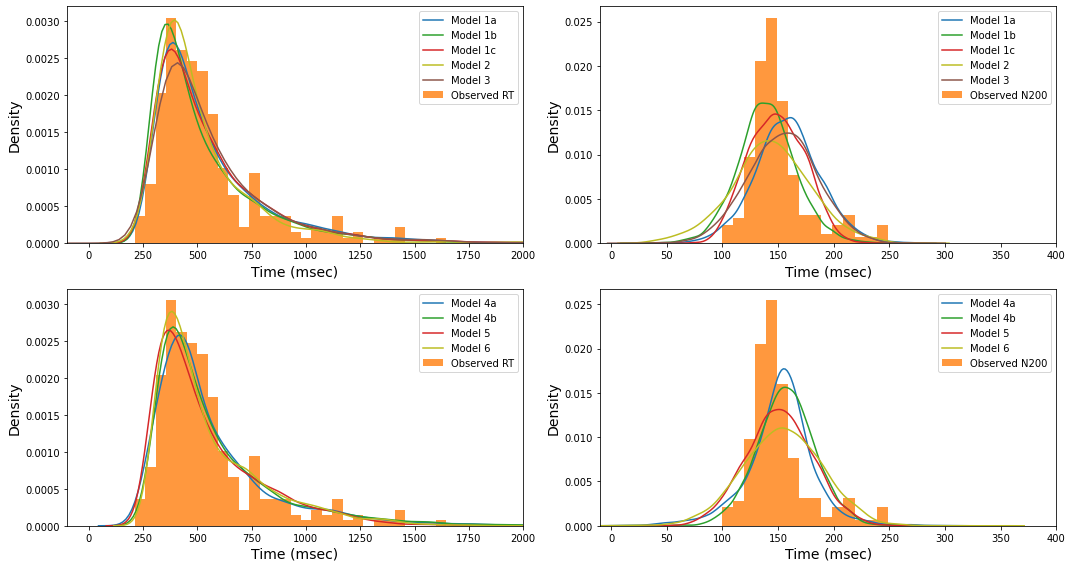

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), tight_layout=True)

# Plot of Model 1a, Model 1b and Model 1c

axes[0,0].hist(1000*np.abs(data_rt_z[:,0]), density=True, bins = 30, color='#ff7f0e', alpha=0.8)
sns.kdeplot(1000*np.abs(x_predict_model1a[:,0,0].flatten()), ax = axes[0,0], color='#1f77b4')
sns.kdeplot(1000*np.abs(x_predict_model1b[:,0,0].flatten()), ax = axes[0,0], color='#2ca02c')
sns.kdeplot(1000*np.abs(x_predict_model1c[:,0,0].flatten()), ax = axes[0,0], color='#d62728')
sns.kdeplot(1000*np.abs(x_predict_model2[:,0,0].flatten()), ax = axes[0,0], color='#bcbd22')
sns.kdeplot(1000*np.abs(x_predict_model3[:,0,0].flatten()), ax = axes[0,0], color='#8c564b')
axes[0,0].set_xlabel('Time (msec)', fontsize = 14)
axes[0,0].set_ylabel('Density', fontsize = 14)
axes[0,0].set_xlim([-100,2000])
axes[0,0].legend(['Model 1a', 'Model 1b', 'Model 1c', 'Model 2', 'Model 3', 'Observed RT'])

axes[0,1].hist(1000*data_rt_z[:,1], density=True, bins = 15, color='#ff7f0e', alpha=0.8)
sns.kdeplot(1000*np.abs(x_predict_model1a[:,0,1].flatten()), ax = axes[0,1], color='#1f77b4')
sns.kdeplot(1000*np.abs(x_predict_model1b[:,0,1].flatten()), ax = axes[0,1], color='#2ca02c')
sns.kdeplot(1000*np.abs(x_predict_model1c[:,0,1].flatten()), ax = axes[0,1], color='#d62728')
sns.kdeplot(1000*np.abs(x_predict_model2[:,0,1].flatten()), ax = axes[0,1], color='#bcbd22')
sns.kdeplot(1000*np.abs(x_predict_model3[:,0,1].flatten()), ax = axes[0,1], color='#8c564b')
axes[0,1].set_xlabel('Time (msec)', fontsize = 14)
axes[0,1].set_ylabel('Density', fontsize = 14)
axes[0,1].set_xlim([-10,400])
axes[0,1].legend([ 'Model 1a', 'Model 1b', 'Model 1c', 'Model 2', 'Model 3', 'Observed N200'])


axes[1,0].hist(1000*np.abs(data_rt_z[:,0]), density=True, bins = 30, color='#ff7f0e', alpha=0.8)
sns.kdeplot(1000*np.abs(x_predict_model4a[:,0,0].flatten()), ax = axes[1,0], color='#1f77b4')
sns.kdeplot(1000*np.abs(x_predict_model4b[:,0,0].flatten()), ax = axes[1,0], color='#2ca02c')
sns.kdeplot(1000*np.abs(x_predict_model5[:,0,0].flatten()), ax = axes[1,0], color='#d62728')
sns.kdeplot(1000*np.abs(x_predict_model6[:,0,0].flatten()), ax = axes[1,0], color='#bcbd22')
axes[1,0].set_xlabel('Time (msec)', fontsize = 14)
axes[1,0].set_ylabel('Density', fontsize = 14)
axes[1,0].set_xlim([-100,2000])
axes[1,0].legend(['Model 4a', 'Model 4b', 'Model 5', 'Model 6', 'Observed RT'])


axes[1,1].hist(1000*data_rt_z[:,1], density=True, bins = 15, color='#ff7f0e', alpha=0.8)
sns.kdeplot(1000*np.abs(x_predict_model4a[:,0,1].flatten()), ax = axes[1,1], color='#1f77b4')
sns.kdeplot(1000*np.abs(x_predict_model4b[:,0,1].flatten()), ax = axes[1,1], color='#2ca02c')
sns.kdeplot(1000*np.abs(x_predict_model5[:,0,1].flatten()), ax = axes[1,1], color='#d62728')
sns.kdeplot(1000*np.abs(x_predict_model6[:,0,1].flatten()), ax = axes[1,1], color='#bcbd22')
axes[1,1].set_xlabel('Time (msec)', fontsize = 14)
axes[1,1].set_ylabel('Density', fontsize = 14)
axes[1,1].set_xlim([-10,400])
axes[1,1].legend(['Model 4a', 'Model 4b', 'Model 5', 'Model 6', 'Observed N200'])


plt.savefig('Figures/face_car_PPD_sub_006.png')